In [2]:
#################################           Load libs                      #############################################
import os
import sys
import pandas as pd
from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.getcwd()))

from src.model.model import Model
%matplotlib inline

from src.utils import metrics_eval, train_test_pred_plot

In [3]:
# Import targets
target = pd.read_csv("../data/series_g.csv", sep=";").series_g.values
# target = pd.read_csv("../data/monthly-beer-production-in-austr.csv", sep=",").iloc[:, -1].values
# target = pd.read_csv("../data/Electric_Production.csv", sep=",").iloc[:, -1].values
# target = pd.read_csv("../data/Chicago_hotels.csv", sep="\t").iloc[:, 3].values
# target = pd.read_csv("../data/PJME_hourly.csv", sep=",").PJME_MW.values

# Generate factors
# f1 = np.arange(1, len(target) + 1).reshape(-1, 1)
# f2 = (np.arange(1, len(target) + 1) ** 2).reshape(-1, 1)
# factors = np.hstack((f1, f2))

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(factors, target, test_size=12, random_state=42, shuffle=False)
y_train, y_test = train_test_split(target, test_size=12, shuffle=False)

configs ={"model": {
            "layers": [
                {
                    "type": "LSTM",
                    "neurons": 128,
                    "return_sequences": False
                },
                {
                    "type": "Dropout",
                    "rate": 0.2
                },
                {
                    "type": "Dense",
                    "activation": "linear"
                }
            ]
        }}

In [5]:
model = Model(configs=configs,
              n_step_in=12,
              n_step_out=len(y_test),
              test_len=len(y_test),
              # n_features=X_train.shape[1]
              loss="mae",
              optimizer="adam"
             )
pprint(model.params)
model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.240692
{'model': {'layers': [{'neurons': 128,
                       'return_sequences': False,
                       'type': 'LSTM'},
                      {'rate': 0.2, 'type': 'Dropout'},
                      {'activation': 'linear', 'type': 'Dense'}]}}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 68,108
Trainable params: 68,108
Non-trainable params: 0
_________________________________________________________________


In [6]:
try:
    os.chdir("../reports")
except:
    os.makedirs("../reports")
    os.chdir("../reports")
new_folder_num = str(len(os.listdir()) + 1)
new_folder = "%s/%s" % ("../reports", new_folder_num)
os.mkdir(new_folder)

[Model] Training Started
[Model] 10 epochs, 12 batch size
Epoch 1/10
10/10 - 3s - loss: 0.2372 - val_loss: 0.2405
Epoch 2/10
10/10 - 0s - loss: 0.0924 - val_loss: 0.1461
Epoch 3/10
10/10 - 0s - loss: 0.0916 - val_loss: 0.1410
Epoch 4/10
10/10 - 0s - loss: 0.0890 - val_loss: 0.1346
Epoch 5/10
10/10 - 0s - loss: 0.0818 - val_loss: 0.1086
Epoch 6/10
10/10 - 0s - loss: 0.0745 - val_loss: 0.1093
Epoch 7/10
10/10 - 0s - loss: 0.0735 - val_loss: 0.1102
Epoch 8/10
10/10 - 0s - loss: 0.0793 - val_loss: 0.1363
Epoch 9/10
10/10 - 0s - loss: 0.0910 - val_loss: 0.1141
Epoch 10/10
10/10 - 0s - loss: 0.0834 - val_loss: 0.1402
Time taken: 0:00:04.737759


/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/src/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')


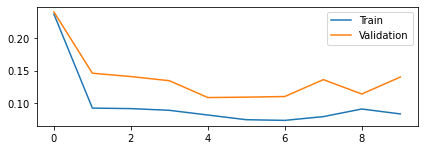

In [7]:
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler

my_callbacks = [callbacks.EarlyStopping(patience=30,
                                     monitor='val_loss')]
my_scaler = MinMaxScaler(feature_range=(0, 1))

model.fit(
          # factors=factors,
          target=target,
          epochs=10,
          batch_size=12,
          callbacks = my_callbacks,
          scaler=my_scaler,
          save_dir=new_folder,
          verbose=2)

In [8]:
predicted = model.predict(
    # factors=X_train[-model.n_step_in:],
    target=y_train[-model.n_step_in:],
    prediction_len=len(y_test)
)

metrics_eval(y_test, predicted, print_result=True, save_dir=new_folder);
train_test_pred_plot(train=y_train, test=y_test, predicted=predicted, save_dir=new_folder)

Mean Absolute Error: 53.889
Mean Squared Error: 5271.533
Root Mean Squared Error: 72.605
Mean absolute percentage error: 10.163
Scaled Mean absolute percentage error: 11.076


/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/src/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')
/Users/levperla/PycharmProjects/Time_Series_Prediction_RNN/src/utils.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('{}.{}'.format(name, fmt), fmt='png')
